<a href="https://colab.research.google.com/github/YaoGroup/DIFFICE_jax/blob/main/tutorial/pinn_syndata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Viscosity inversion from synthetic data via PINNs

Fast running the code requires **GPU hardware** to accelerate.

To choose GPU hardware, click the "Edit" in the toolbar above and select "Notebook settings".

In the pop-up window, under the "Hardware accelerator", select "T4 GPU"

To ensure the code to run correctly in the colab, install the specific version of JAX below.

(Note that only using the GPU version of JAX, combined with the selection of GPU hardware as mentioned above, can eventually accelerate the training.)

In [1]:
# Install specific version (0.4.23) of JAX and Jaxlib
!pip install --upgrade jax==0.4.23 jaxlib==0.4.23+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Verify the installed version
import jax
print(jax.__version__)

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
0.4.23


Copying required python functions from the [DIFFICE_jax](https://github.com/YaoGroup/DIFFICE_jax) GitHub repository

In [2]:
!git clone https://github.com/YaoGroup/DIFFICE_jax

Cloning into 'DIFFICE_jax'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 645 (delta 294), reused 85 (delta 85), pack-reused 280
Receiving objects: 100% (645/645), 17.90 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (385/385), done.


Importing the required JAX library and function file from GitHub repository

In [3]:
import jax.numpy as jnp
import numpy as np
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

from DIFFICE_jax.data.sampling import data_sample_create
from DIFFICE_jax.equation.ssa_eqn_iso import vectgrad, gov_eqn, front_eqn
from DIFFICE_jax.model.initialization import init_MLP
from DIFFICE_jax.model.networks import solu_create
from DIFFICE_jax.model.loss import loss_create
from DIFFICE_jax.model.prediction import predict
from DIFFICE_jax.optimizer.optimizer import adam_optimizer, lbfgs_optimizer
from DIFFICE_jax.tutorial.load_syndata import iceshelf_data


# Setting hyperparameters

hyper-parameters used for the training. Users are free to modify their value and check their influence on the training results


In [4]:
# select a random seed
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 5  # number of hidden layers
n_unit = 30  # number of units in each hidden layer

# select the weight for the equation and boundary conditions
lw = [0.05, 0.1]

# number of points sampled for each variable from the synthetic data
n_smp = 4000
# number of collocation points to evaluate the equation residue
n_col = 4000
# number of collocation points to evalute boundary conditions
n_cbd = 600
# group all the points
n_pt = jnp.array([n_smp, n_col, n_cbd], dtype='int32')

# double all the points for L-BFGS training (fixed points over iterations)
n_pt2 = n_pt * 2

# select the file of synthetic data
DataFile = 'SynData_exp1.mat'

# re-organized the synthetic data for the PINN code
data_all = iceshelf_data(DataFile, step=1)
# extract the scale information for each variable
scale = data_all[4][0:2]


# Initializing the model and the loss function

In [5]:
# initialize the weights and biases of the network
trained_params = init_MLP(keys[0], n_hl, n_unit)

# create the solution function
pred_u = solu_create()

# create the data sampling function for Adam training
dataf = data_sample_create(data_all, n_pt)
keys_adam = random.split(keys[1], 5)
# generate the data
data = dataf(keys_adam[0])

# create the data sampling function for L-BFGS training
dataf_l = data_sample_create(data_all, n_pt2)
key_lbfgs = random.split(keys[2], 5)


# group the gov. eqn and bdry cond.
eqn_all = (gov_eqn, front_eqn)
# create the loss function
NN_loss = loss_create(pred_u, eqn_all, scale, lw)
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]


# Training using ADAM optimizer

Required at least 10000 iterations of Adam,
plus 10000 iterations of L-BFGS later
to ensure a successful training

In [6]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 8000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 20 | Loss: 1.2833e-01 | Loss_d: 4.0596e-01 | Loss_e: 1.9420e-02 | Loss_b: 2.6441e-03
Step: 40 | Loss: 7.5519e-02 | Loss_d: 2.3756e-01 | Loss_e: 3.2483e-02 | Loss_b: 4.4578e-03
Step: 60 | Loss: 7.0051e-02 | Loss_d: 2.2101e-01 | Loss_e: 1.9532e-02 | Loss_b: 2.9027e-03
Step: 80 | Loss: 6.2843e-02 | Loss_d: 1.9623e-01 | Loss_e: 5.2369e-02 | Loss_b: 5.6134e-03
Step: 100 | Loss: 5.4533e-02 | Loss_d: 1.6603e-01 | Loss_e: 1.1903e-01 | Loss_b: 1.0622e-02
Step: 120 | Loss: 4.7288e-02 | Loss_d: 1.3928e-01 | Loss_e: 1.7907e-01 | Loss_b: 1.8174e-02
Step: 140 | Loss: 4.3688e-02 | Loss_d: 1.2749e-01 | Loss_e: 1.7045e-01 | Loss_b: 2.6130e-02
Step: 160 | Loss: 4.0992e-02 | Loss_d: 1.2037e-01 | Loss_e: 1.3289e-01 | Loss_b: 3.0573e-02
Step: 180 | Loss: 4.1123e-02 | Loss_d: 1.2166e-01 | Loss_e: 1.1292e-01 | Loss_b: 3.1823e-02
Step: 200 | Loss: 3.8853e-02 | Loss_d: 1.1508e-01 | Loss_e: 1.0224e-01 | Loss_b: 3.0934e-02
Step: 220 | Loss: 3.6368e-02 | Loss_d: 1.0762e-01 | Loss_e: 9.5359e-02 | Loss_b: 3.0

# Training using L-BFGS optimizer
Extra training using L-BFGS to reach higher accuracy

Recommended number of iterations: 10000

In [7]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)

Streaming output truncated to the last 5000 lines.
Step: NaN | Loss: 3.6256e-05 | Loss_d: 6.4392e-05 Loss_e: 4.6827e-04 | Loss_b: 2.7237e-04
Step: NaN | Loss: 3.6249e-05 | Loss_d: 6.4385e-05 Loss_e: 4.6806e-04 | Loss_b: 2.7234e-04
Step: NaN | Loss: 3.6236e-05 | Loss_d: 6.4356e-05 Loss_e: 4.6819e-04 | Loss_b: 2.7215e-04
Step: NaN | Loss: 3.6266e-05 | Loss_d: 6.4404e-05 Loss_e: 4.7037e-04 | Loss_b: 2.7152e-04
Step: NaN | Loss: 3.6231e-05 | Loss_d: 6.4343e-05 Loss_e: 4.6853e-04 | Loss_b: 2.7196e-04
Step: NaN | Loss: 3.6225e-05 | Loss_d: 6.4336e-05 Loss_e: 4.6884e-04 | Loss_b: 2.7167e-04
Step: NaN | Loss: 3.6224e-05 | Loss_d: 6.4330e-05 Loss_e: 4.6873e-04 | Loss_b: 2.7174e-04
Step: NaN | Loss: 3.6218e-05 | Loss_d: 6.4325e-05 Loss_e: 4.6861e-04 | Loss_b: 2.7167e-04
Step: NaN | Loss: 3.6212e-05 | Loss_d: 6.4335e-05 Loss_e: 4.6858e-04 | Loss_b: 2.7139e-04
Step: NaN | Loss: 3.6211e-05 | Loss_d: 6.4327e-05 Loss_e: 4.6852e-04 | Loss_b: 2.7146e-04
Step: NaN | Loss: 3.6229e-05 | Loss_d: 6.4387e-05

# Computing the output of trained networks

Compute the solution variables and equation residue at high-resolution grids

In [8]:
# Function of solution and equation residues based on trained networks
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:6]
f_eqn = lambda x: gov_eqn(f_u, x, scale)

# group all the function
func_all = (f_u, f_gu, f_eqn)

# calculate the solution and equation residue at given grids for visualization
results = predict(func_all, data_all)


# Plotting the results:

Compare the synthetic data for either velocity or thickness with the corresponding network approximation

Text(0.5, 1.0, 'Network approx. $u(x,y)$')

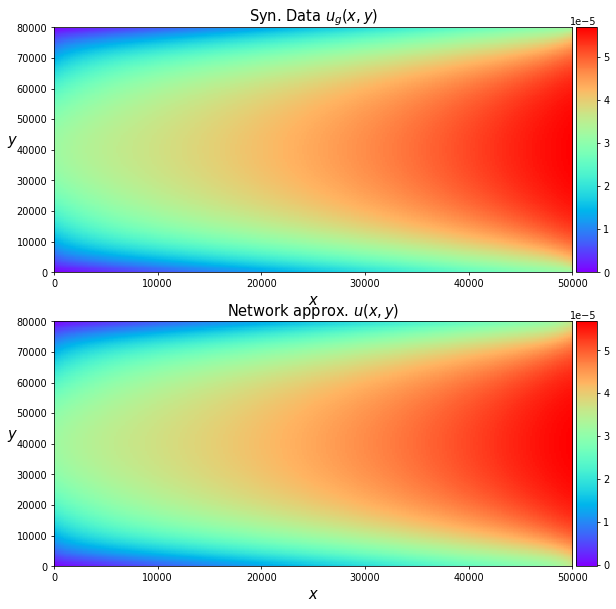

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

u_g = results['u_g']
u = results['u']

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2,1,1)
h = ax.imshow(u_g, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Syn. Data $u_g(x,y)$', fontsize = 15)


ax2 = plt.subplot(2,1,2)
h2 = ax2.imshow(u, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize = 15)
ax2.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax2.set_title('Network approx. $u(x,y)$', fontsize = 15)


Compare the given viscosity profile with inferred viscosity via PINNs

Text(0.5, 1.0, 'PINN inversion $\\mu(x,y)$')

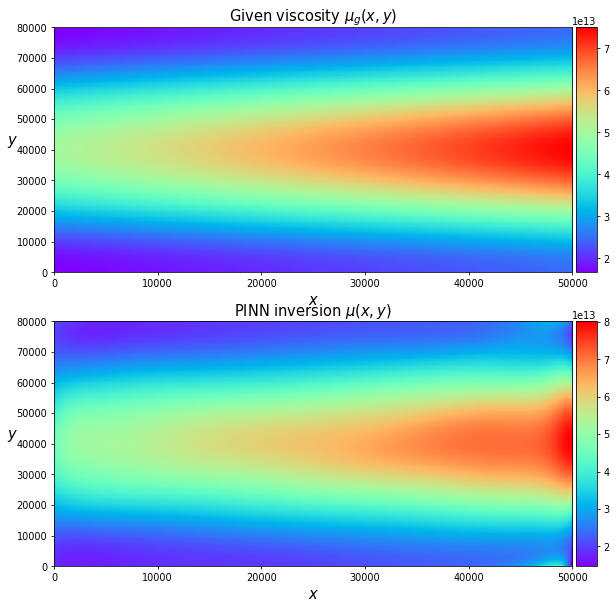

In [10]:
# load the given viscosity (ground truth)
mu_g = data_all[5]
# load the PINN inference of viscosity
mu = results['mu']

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2,1,1)
h = ax.imshow(mu_g, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Given viscosity $\mu_g(x,y)$', fontsize = 15)


ax2 = plt.subplot(2,1,2)
h2 = ax2.imshow(mu, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize = 15)
ax2.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax2.set_title('PINN inversion $\mu(x,y)$', fontsize = 15)
